# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 06.12.2021

Мягкий дедлайн: 18.12.2021 23:59 MSK

Жёсткий дедлайн: 19.12.2021 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
#! pip install --upgrade lightgbm
#! pip install optuna

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test,
                                                    y_test,
                                                    test_size=0.5,
                                                    random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 2.16 s, sys: 20.9 ms, total: 2.18 s
Wall time: 2.2 s
Train ROC-AUC 0.9894
Valid ROC-AUC 0.9189
Test ROC-AUC 0.9179


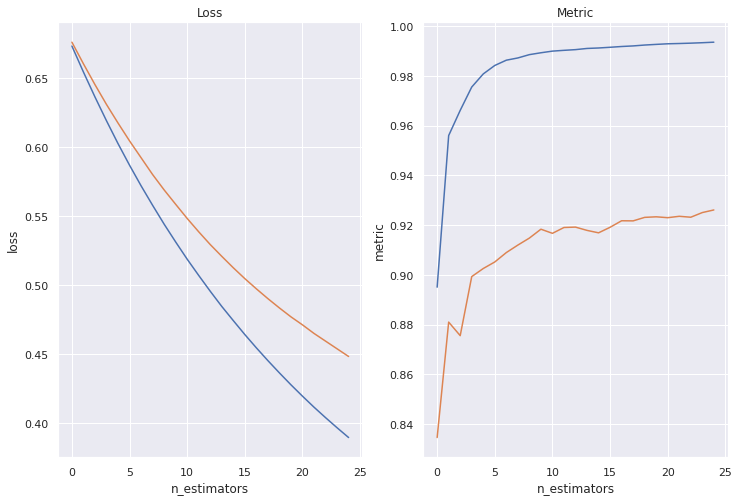

In [ ]:
# plot example
boosting = Boosting(n_estimators=25, plot=True)

boosting.fit(x_train, y_train, x_valid, y_valid)

## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
results = {'train': [], 'test': [], 'max_depth': []}

depths = range(1, 30, 2)
# YOUR CODE:
for max_depth in depths:
    boosting = Boosting(base_model_params={'max_depth': max_depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)

    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))
    results['max_depth'].append(max_depth)

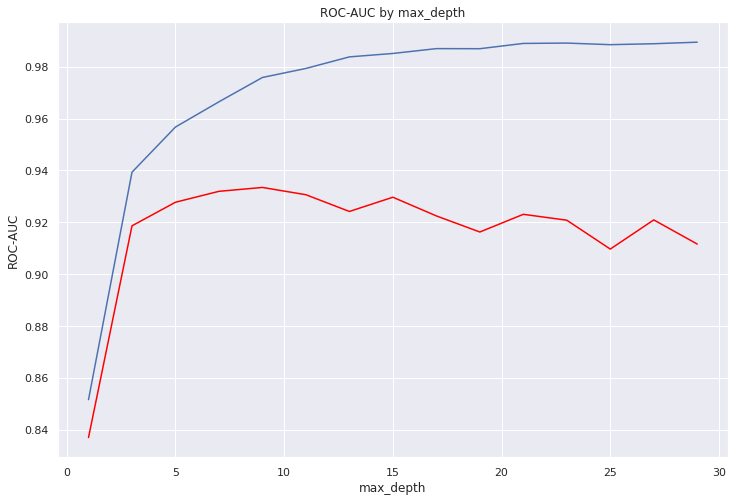

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, results['train'], label='train')
plt.plot(depths, results['test'], label='test', color='red')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC by max_depth')
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

При максимальной глубине = 7. При маленьких значениях максимальной глубины модель не так хорошо улавливает закономерности в данных, при большой максимальной глубине модель переобучается под обучающую выборку, следовательно, качество на тестовой выборке падает

In [ ]:
best_depth = np.argmax(results['test'])
print(f"BEST test ROC_AUC: {results['test'][best_depth]:.5f}", end=' ')
print(f"max_depth: {results['max_depth'][best_depth]}")

BEST test ROC_AUC: 0.93341 max_depth: 9


## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

In [ ]:
import itertools
import pandas as pd

results = pd.DataFrame(
    index=['boosting', 'boosting', 'lightgbm', 'lightgbm'],
    columns=['optimization', 'valid_roc_auc', 'test_roc_auc'])

In [ ]:
def train_boosting(model_params):
    model = Boosting(
        n_estimators=int(model_params['n_estimators']),
        subsample=model_params['subsample'],
        learning_rate=model_params['learning_rate'],
        base_model_params={'max_depth': model_params['max_depth']})
    model.fit(x_train, y_train, x_valid, y_valid)
    val_score = np.round(model.score(x_valid, y_valid), 5)
    test_score = np.round(model.score(x_test, y_test), 5)
    return val_score, test_score

In [ ]:
depths = [3, 5, 7]
estimators = [25, 50, 100]
learning_rate = [1e-3, 1e-2, 1e-1]
subsample = [0.2, 0.3]
hparams_combination = list(
    itertools.product(estimators, learning_rate, depths, subsample))

In [ ]:
best_val_auc = -np.inf

for val in hparams_combination:
    params = {
        'n_estimators': val[0],
        'learning_rate': val[1],
        'max_depth': val[2],
        'subsample': val[3],
    }
    val_score, test_score = train_boosting(params)
    if val_score > best_val_auc:
        best_boosting_params = params.copy()
        best_val_auc = val_score
        best_test_score = test_score

In [ ]:
results.iloc[0, :] = ['grid search', best_val_auc, best_test_score]
print(f"Boosting with grid search tuning valid score: {best_val_auc},", end=' ')
print(f"test score: {best_test_score}\n")
best_boosting_params

Boosting with grid search tuning valid score: 0.94102, test score: 0.93956



{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.3}

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [ ]:
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import roc_auc_score
import itertools

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'AUC',
    'random_state': 42,
    'verbose': -1,
}

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid)

model = lgb.train(
    params=params,
    train_set=lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[log_evaluation(25)],
)
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))
test_score = roc_auc_score(y_test, model.predict(x_test))
print(f"Train ROC-AUC: {train_score:.5f}")
print(f"Valid ROC-AUC: {valid_score:.5f}")
print(f"Test ROC-AUC: {test_score:.5f}")

[25]	training's auc: 0.971063	valid_1's auc: 0.940275
[50]	training's auc: 0.978255	valid_1's auc: 0.945124
[75]	training's auc: 0.981633	valid_1's auc: 0.946314
[100]	training's auc: 0.983756	valid_1's auc: 0.946272
Train ROC-AUC: 0.98376
Valid ROC-AUC: 0.94627
Test ROC-AUC: 0.94042


In [ ]:
def train_lgb(model_params):
    lgb_train = lgb.Dataset(x_train, y_train)
    model = lgb.train(params=model_params,
                      train_set=lgb_train,
                      verbose_eval=False)
    val_score = np.round(roc_auc_score(y_valid, model.predict(x_valid)), 5)
    test_score = np.round(roc_auc_score(y_test, model.predict(x_test)), 5)
    return val_score, test_score

In [ ]:
depths = [-1, 3, 5, 7, 9]
iterations = [100, 200, 300]
learning_rate = [1e-3, 1e-2, 1e-1]
subsample = [0.1, 0.2, 0.3, 0.6, 0.7, 0.8, 0.9, 1]
reg_lambda = [0, 5, 10]
hparams_combination = list(
    itertools.product(iterations, learning_rate, depths, subsample,
                      reg_lambda))

In [ ]:
best_val_auc = -np.inf
for val in hparams_combination:
    params = {
        'objective': 'binary',
        'metric': 'AUC',
        'random_state': 42,
        'verbose': -1,
        'num_iterations': val[0],
        'learning_rate': val[1],
        'max_depth': val[2],
        'subsample': val[3],
        'reg_lambda': val[4]
    }
    val_score, test_score = train_lgb(params)
    if val_score > best_val_auc:
        best_lgb_params = params.copy()
        best_val_auc = val_score
        best_test_score = test_score

In [ ]:
results.iloc[2, :] = ['grid search', best_val_auc, best_test_score]
print(f"LGB with grid search tuning valid score: {best_val_auc},", end=' ')
print(f"test score: {best_test_score}\n")
best_lgb_params

LGB with grid search tuning valid score: 0.94712, test score: 0.94009



{'objective': 'binary',
 'metric': 'AUC',
 'random_state': 42,
 'verbose': -1,
 'num_iterations': 200,
 'learning_rate': 0.1,
 'max_depth': 5,
 'subsample': 0.1,
 'reg_lambda': 0}

### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def lgb_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'AUC',
        'random_state': 42,
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'reg_lambda': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'num_iterations': trial.suggest_categorical('num_iterations', [100, 200, 300]),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 3, 5, 7, 9]),
        'subsample': trial.suggest_float('subsample', 0, 1)
    }
    score, test_score = train_lgb(params)
    return score


def boosting_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    score, test_score = train_boosting(params)
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lgb_objective, n_trials=100)
trial = study.best_trial
lgb_optuna_params = {
    'objective': 'binary',
    'metric': 'AUC',
    'random_state': 42,
    'verbose': -1
}
for key, value in trial.params.items():
    lgb_optuna_params[key] = value

val_score, test_score = train_lgb(lgb_optuna_params)
results.iloc[3, :] = ['optuna', val_score, test_score]
print(f"LGB valid score with optuna: {val_score}, test score: {test_score}\n")
lgb_optuna_params

LGB valid score with optuna: 0.94801, test score: 0.94018



{'objective': 'binary',
 'metric': 'AUC',
 'random_state': 42,
 'verbose': -1,
 'learning_rate': 0.11914284266059853,
 'lambda_l1': 0.00214712195283317,
 'num_iterations': 200,
 'max_depth': 5,
 'subsample': 0.5236146156753692}

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(boosting_objective, n_trials=50)
trial = study.best_trial
boosting_optuna_params = {}

for key, value in trial.params.items():
    boosting_optuna_params[key] = value

val_score, test_score = train_boosting(boosting_optuna_params)
results.iloc[1, :] = ['optuna', val_score, test_score]
print(
    f"Boosting valid score with optuna: {val_score}, test score: {test_score}\n"
)
boosting_optuna_params

Boosting valid score with optuna: 0.94263, test score: 0.94029



{'n_estimators': 174,
 'learning_rate': 0.23322745781444654,
 'max_depth': 8,
 'subsample': 0.2094805194476195,
 'min_samples_leaf': 2}

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict_proba(x_valid)[:, 1]
logreg_test, logreg_pred = calibration_curve(y_valid, logreg_pred)

In [ ]:
boosting = Boosting(
    n_estimators=int(boosting_optuna_params['n_estimators']),
    subsample=boosting_optuna_params['subsample'],
    learning_rate=boosting_optuna_params['learning_rate'],
    base_model_params={'max_depth': boosting_optuna_params['max_depth']})

boosting.fit(x_train, y_train, x_valid, y_valid)
boosting_pred = boosting.predict_proba(x_valid)[:, 1]

boosting_test, boosting_pred = calibration_curve(y_valid, boosting_pred)

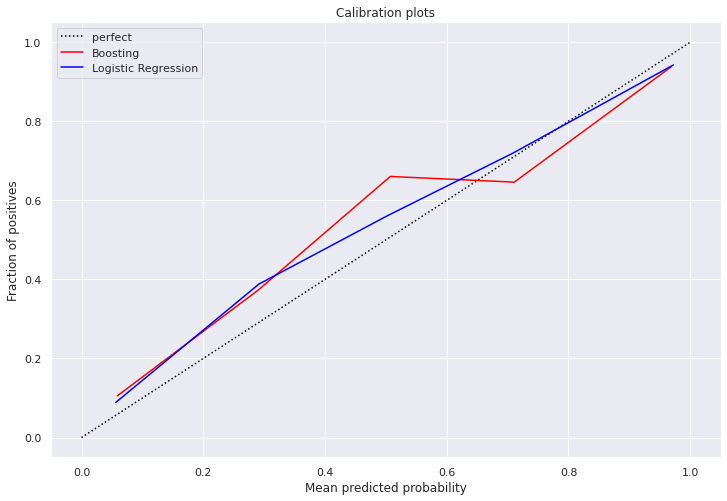

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], linestyle='dotted', label='perfect', color='black')
plt.plot(boosting_pred, boosting_test, label='Boosting', color='red')
plt.plot(logreg_pred, logreg_test, label='Logistic Regression', color='blue')
plt.ylabel('Fraction of positives')
plt.xlabel('Mean predicted probability')
plt.title('Calibration plots')
plt.legend()
plt.show()

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

In [ ]:
def train_boosting_with_feats(model_params,
                              features=np.arange(x_train.shape[1])):
    model = Boosting(
        n_estimators=int(model_params['n_estimators']),
        subsample=model_params['subsample'],
        learning_rate=model_params['learning_rate'],
        base_model_params={'max_depth': model_params['max_depth']})
    model.fit(x_train[:, features], y_train, x_valid[:, features], y_valid)
    val_score = np.round(model.score(x_valid[:, features], y_valid), 5)
    test_score = np.round(model.score(x_test[:, features], y_test), 5)
    return model.feature_importances_, val_score, test_score

In [ ]:
boosting_importances, _, _ = train_boosting_with_feats(boosting_optuna_params)
logreg_importances = (np.abs(logreg.coef_) / np.sum(np.abs(logreg.coef_)))[0]

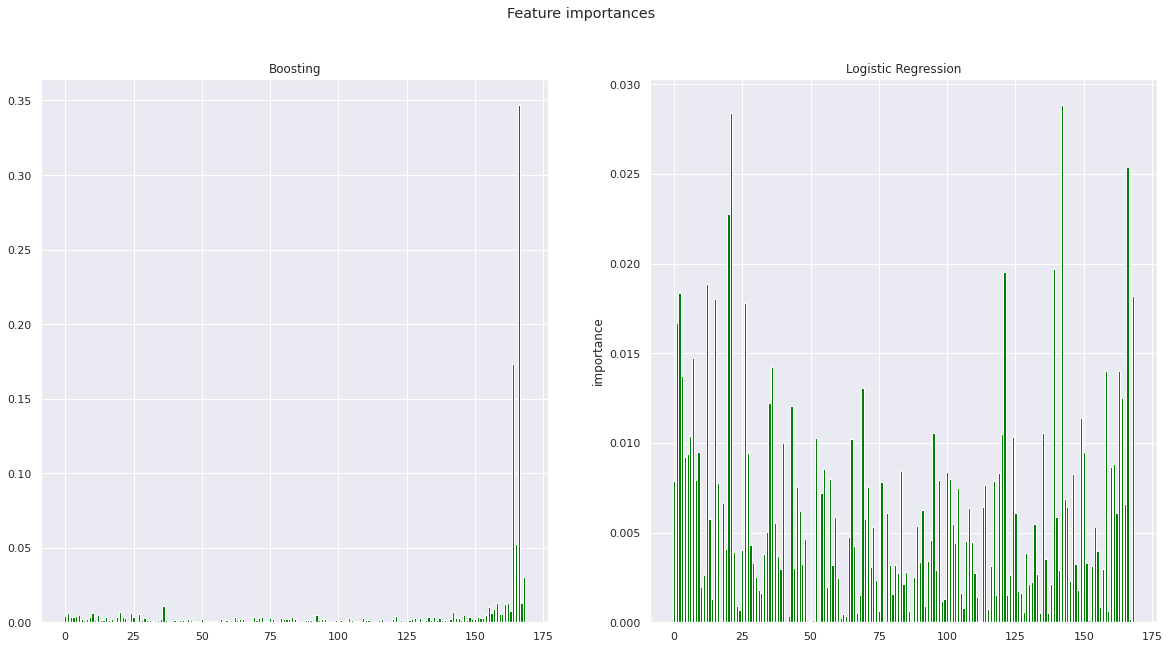

In [ ]:
x = range(x_train.shape[1])
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].bar(x, boosting_importances, color='green')
axes[0].set_title('Boosting')
axes[1].set_ylabel('feature')
axes[1].set_ylabel('importance')
axes[1].bar(x, logreg_importances, color='green')
axes[1].set_title('Logistic Regression')
axes[1].set_ylabel('feature')
axes[1].set_ylabel('importance')
plt.suptitle('Feature importances')
plt.show()

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
results.iloc[1, :]

optimization      optuna
valid_roc_auc    0.94263
test_roc_auc     0.94029
Name: boosting, dtype: object

In [ ]:
for i in np.linspace(0.05, 0.5, 10):
    treshold = np.quantile(boosting_importances, i)
    feats = np.where(boosting_importances > treshold)[0]
    _, valid_score, test_score = train_boosting_with_feats(
        boosting_optuna_params, feats)
    print(f"Treshold: quantile({i:.2f}), number of features: {len(feats)}")
    print(f"Valid ROC-AUC: {valid_score}, test ROC-AUC: {test_score}")
    print()

Treshold: quantile(0.05), number of features: 160
Valid ROC-AUC: 0.94008, test ROC-AUC: 0.94055

Treshold: quantile(0.10), number of features: 152
Valid ROC-AUC: 0.94152, test ROC-AUC: 0.93985

Treshold: quantile(0.15), number of features: 143
Valid ROC-AUC: 0.94235, test ROC-AUC: 0.93973

Treshold: quantile(0.20), number of features: 135
Valid ROC-AUC: 0.94266, test ROC-AUC: 0.94069

Treshold: quantile(0.25), number of features: 126
Valid ROC-AUC: 0.94168, test ROC-AUC: 0.93869

Treshold: quantile(0.30), number of features: 118
Valid ROC-AUC: 0.9414, test ROC-AUC: 0.94139

Treshold: quantile(0.35), number of features: 110
Valid ROC-AUC: 0.94188, test ROC-AUC: 0.94027

Treshold: quantile(0.40), number of features: 101
Valid ROC-AUC: 0.94209, test ROC-AUC: 0.93863

Treshold: quantile(0.45), number of features: 93
Valid ROC-AUC: 0.94196, test ROC-AUC: 0.93862

Treshold: quantile(0.50), number of features: 84
Valid ROC-AUC: 0.94314, test ROC-AUC: 0.93822



При некоторых порогах удаления признаков ROC-AUC на тестовой выборке улучшается

## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

In [ ]:
results

,optimization,valid_roc_auc,test_roc_auc
boosting,grid search,0.94102,0.93956
boosting,optuna,0.94263,0.94029
lightgbm,grid search,0.94712,0.94009
lightgbm,optuna,0.94801,0.94018


In [ ]:
def train_boosting(model_params):
    model = Boosting(
        n_estimators=int(model_params['n_estimators']),
        subsample=model_params['subsample'],
        learning_rate=model_params['learning_rate'],
        base_model_params={'max_depth': model_params['max_depth']})
    model.fit(x_train, y_train, x_valid, y_valid)
    return model.predict_proba(x_valid)[:, 1], model.predict_proba(x_test)[:,1]

In [ ]:
def train_lgb(model_params):
    lgb_train = lgb.Dataset(x_train, y_train)
    model = lgb.train(params=model_params,
                      train_set=lgb_train,
                      verbose_eval=False)
    return model.predict(x_valid), model.predict(x_test)

In [ ]:
valid_boosting_1, test_boosting_1 = train_boosting(best_boosting_params)
valid_boosting_2, test_boosting_2 = train_boosting(boosting_optuna_params)

valid_lgb_1, test_lgb_1 = train_lgb(best_lgb_params)
valid_lgb_2, test_lgb_2 = train_lgb(lgb_optuna_params)

In [ ]:
valid_blend = (valid_lgb_1 + valid_lgb_2 + valid_boosting_1 +
               valid_boosting_2) / 4
test_blend = (test_lgb_1 + test_lgb_2 + test_boosting_1 + test_boosting_2) / 4
test_score = roc_auc_score(y_test, test_blend)
print(f"Blending valid ROC-AUC: {roc_auc_score(y_valid,valid_blend):5f}")
print(f"Blending test ROC-AUC: {test_score:5f}")
print(f"Improvement on test set: {test_score-results['test_roc_auc'].max():.5f}")

Blending valid ROC-AUC: 0.946425
Blending test ROC-AUC: 0.941881
Improvement on test set: 0.00159


По сравнению с прогнзом лучшей модели (lightgbm с гиперпараметрами, настроенными optuna) блендинг улучшает метрику на тестовом наборе данных на 0.00159

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2022 года?